## Isolated Wing with Propeller BET Model

This notebook shows how to set up a **BET disk** in front of an isolated wing using the Flow360 Python API. We load the geometry, define mesh refinements (including an axisymmetric region for the rotor), build a BET disk model from an XROTOR file, and submit the case through the project interface.

The geometry consists of a BET disk in front of an isolated wing:

![isolated wing](figures/isolated_wing.png)

## 1. Create project from geometry

We first import the Flow360 Python API, load the BET example files, and create a project from the isolated-wing geometry. This sets up the geometry object we will use for meshing, modeling, and post-processing.

In [1]:
import flow360 as fl
from flow360.examples import TutorialBETDisk

TutorialBETDisk.get_files()

project = fl.Project.from_geometry(
    TutorialBETDisk.geometry, name="Tutorial BETDisk from Python"
)
geometry = project.geometry

# show face and edge groupings
geometry.group_faces_by_tag("faceName")
geometry.group_edges_by_tag("edgeName")

Output()

[12:12:01] INFO: Geometry successfully submitted:                                                                  
                   type        = Geometry                                                                          
                   name        = Tutorial BETDisk from Python                                                      
                   id          = geo-25e23e0d-fd3a-4772-90d6-47b912d35eff                                          
                   status      = uploaded                                                                          
                   project id  = prj-82a38889-787a-4db3-8b46-a6865fda2a58                                          
           

           INFO: Waiting for geometry to be processed.

Output()

## 2. Define BET disk refinements

Here we define an axisymmetric refinement region around the rotor using a cylindrical volume and `AxisymmetricRefinement`. The cylinder approximates where the BET disk acts, and the refinement spacings control the local mesh resolution in axial, radial, and circumferential directions. Choosing a cylinder slightly larger than the rotor helps ensure the rotor-affected region is well resolved.

In [2]:
with fl.SI_unit_system:
    cylinder1 = fl.Cylinder(
        name="cylinder1",
        axis=[1, 0, 0],
        center=[-2.0, 5.0, 0],
        outer_radius=4.0,
        height=0.6,
    )

    bet_disk_refinement = fl.AxisymmetricRefinement(
        name="BET_Disk",
        spacing_axial=0.02,
        spacing_radial=0.03,
        spacing_circumferential=0.06,
        entities=cylinder1,
    )

[12:12:22] INFO: using: SI unit system for unit inference.

## 3. Define meshing parameters

Next we define the global meshing parameters, combining an automatically generated farfield with additional local refinements. A second cylinder provides a region of uniform refinement around the wing and rotor, while the BET disk refinement from the previous step is included to resolve the rotor region. These settings control the overall mesh size, boundary layer resolution, and key refinement zones for the simulation.

In [3]:
with fl.SI_unit_system:
    cylinder2 = fl.Cylinder(
        name="cylinder2",
        axis=[1, 0, 0],
        center=[0, 5, 0],
        outer_radius=4.1,
        height=5,
    )
    farfield = fl.AutomatedFarfield()
    meshing_params = fl.MeshingParams(
        defaults=fl.MeshingDefaults(
            surface_max_edge_length=0.5,
            boundary_layer_growth_rate=1.15,
            boundary_layer_first_layer_thickness=1e-06,
        ),
        volume_zones=[farfield],
        refinements=[
            bet_disk_refinement,
            fl.UniformRefinement(
                name="cylinder_refinement", spacing=0.1, entities=[cylinder2]
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

## 4. Define BET disk model
The BET disk model is defined from an xrotor file. This file contains a 2D database of drag, lift and moment coefficients of the airfoils used in the blades depending on Reynolds and Mach numbers.

[Download XROTOR file](https://simcloud-public-1.s3.amazonaws.com/betTutorial/xv15_rotor_26deg.xrotor) to get the file used in this tutorial so you can inspect its structure. A detailed explanation of the xrotor translation tool is written in [BET translators](../../../knowledge_base/PreProcessing/bet_disk/bet_disk.rst).

In the next code cell we will:
- Define a cylindrical volume that approximates the physical rotor disk where the BET forces will be applied.
- Load the XROTOR file using a dedicated `fl.XROTORFile` helper so Flow360 can interpret the aerodynamic tables.
- Build a `fl.BETDisk` model from the XROTOR data and specify the rotor operating conditions (rotation direction, rotational speed, reference chord, number of loading nodes, and units).

This BET model will later be attached to the simulation as one of the physical models in the `models` list.

In [4]:
with fl.SI_unit_system:
    bet_cylinder = fl.Cylinder(
        name="bet_cylinder",
        axis=[-1, 0, 0],
        center=[-2.0, 5.0, 0.0],
        outer_radius=3.81,
        height=0.4572,
    )

    xrotor_file = fl.XROTORFile(file_path=TutorialBETDisk.extra["xrotor"])
    bet_disk_model = fl.BETDisk.from_xrotor(
        file=xrotor_file,
        rotation_direction_rule="rightHand",
        omega=460 * fl.u.rpm,
        chord_ref=0.3556,
        n_loading_nodes=20,
        entities=bet_cylinder,
        angle_unit=fl.u.deg,
        length_unit=fl.u.m,
    )

           INFO: using: SI unit system for unit inference.

## 5. Define `SimulationParams`

We now collect all inputs into a single `fl.SimulationParams` object. This includes the meshing setup, reference geometry, operating condition, and steady-state time-stepping. We also specify the physical and boundary models (walls, farfield, symmetry, fluid solver, and the BET disk) and choose which volume and surface quantities to output for later analysis.

In [5]:
with fl.SI_unit_system:
    params = fl.SimulationParams(
        meshing=meshing_params,
        reference_geometry=fl.ReferenceGeometry(
            moment_center=[0.375, 0, 0],
            moment_length=[1.26666666, 1.26666666, 1.26666666],
            area=12.5,
        ),
        operating_condition=fl.AerospaceCondition.from_mach(
            mach=0.182,
            alpha=5 * fl.u.deg,
            reference_mach=0.54,
        ),
        time_stepping=fl.Steady(
            max_steps=10000, CFL=fl.RampCFL(initial=1, final=100, ramp_steps=2000)
        ),
        models=[
            fl.Wall(
                surfaces=[
                    geometry["wing"],
                    geometry["tip"],
                ],
            ),
            fl.Freestream(surfaces=farfield.farfield),
            fl.SlipWall(surfaces=farfield.symmetry_planes),
            fl.Fluid(
                navier_stokes_solver=fl.NavierStokesSolver(
                    absolute_tolerance=1e-12,
                ),
                turbulence_model_solver=fl.SpalartAllmaras(
                    absolute_tolerance=1e-10,
                    update_jacobian_frequency=1,
                    equation_evaluation_frequency=1,
                ),
            ),
            bet_disk_model,
        ],
        outputs=[
            fl.VolumeOutput(
                output_fields=[
                    "primitiveVars",
                    "betMetrics",
                    "qcriterion",
                ],
            ),
            fl.SurfaceOutput(
                surfaces=geometry["*"],
                output_fields=[
                    "primitiveVars",
                    "Cp",
                    "Cf",
                    "CfVec",
                ],
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

## 6. Run case

We now launch the simulation case from the project using the `SimulationParams` we assembled. The returned `case` object will be used to monitor the run and access results for post-processing.

In [6]:
case = project.run_case(
    params=params, name="Case of tutorial BETDisk from Python", use_beta_mesher=True
)

           INFO: using: SI unit system for unit inference.

[12:12:24] INFO: Selecting beta/in-house mesher for possible meshing tasks.

[12:12:26] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = Case of tutorial BETDisk from Python                                              
                   id          = case-806e077b-b493-47ce-b776-9a4f5ef46290                                         
                   status      = pending                                                                           
                   project id  = prj-82a38889-787a-4db3-8b46-a6865fda2a58                                          
           

## 7. Post-processing

Finally, we wait for the case to finish, read the results, and make a few simple plots. We look at the evolution of integrated lift and drag coefficients and the nonlinear residuals to assess convergence and overall solution quality.

Output()

Output()

[12:23:48] INFO: Saved to /tmp/tmpri5txw3w/3bd23e60-41af-4f9b-bfcd-a106345e2575.csv

Output()

[12:23:50] INFO: Saved to /tmp/tmpri5txw3w/4bf86786-76f5-4e18-94a0-2cfe0d4b5a35.csv

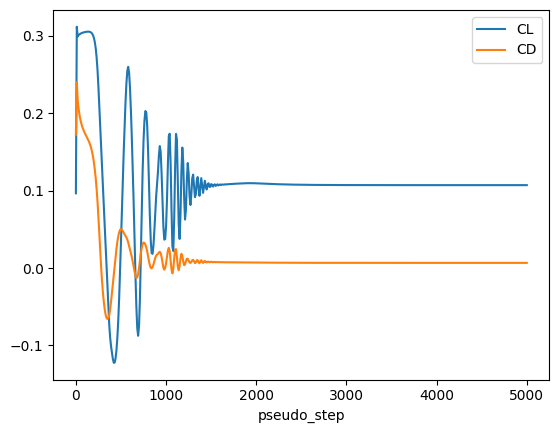

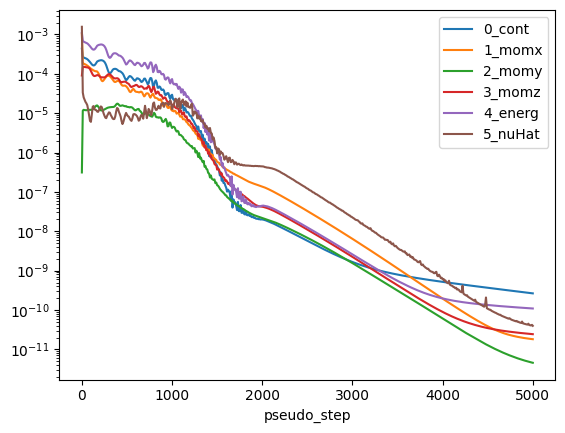

In [7]:
import matplotlib.pyplot as plt

case.wait()
results = case.results

total_forces = results.total_forces.as_dataframe()
total_forces.plot("pseudo_step", ["CL", "CD"])

non_linear = results.nonlinear_residuals.as_dataframe()
non_linear.plot(
    "pseudo_step",
    ["0_cont", "1_momx", "2_momy", "3_momz", "4_energ", "5_nuHat"],
    logy=True,
)
plt.show()